In [6]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from datasets import Features, Value
from transformers import BitsAndBytesConfig
import gc
import torch
from torch.utils.data import DataLoader

In [ ]:
features = Features({
    'reviewText': Value('string'),
    'overall': Value('int64')
})

# Load the dataset
dataset = load_dataset('csv', data_files='./data/train_data.csv', split='train', features=features).select(range(100000))

# Convert the dataset to a pandas DataFrame for undersampling
df = dataset.to_pandas()

# Perform undersampling on the raw data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.drop(columns=['overall']), df['overall'])
balanced_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['overall'])], axis=1)

# Convert the balanced DataFrame back to a Hugging Face Dataset
balanced_dataset = Dataset.from_pandas(balanced_df)

# Filter out long reviews after undersampling
def filter_long_reviews(example):
    return len(example['reviewText']) <= 1000

filtered_dataset = balanced_dataset.filter(filter_long_reviews)

# Split the filtered dataset into train and validation sets
train_test_split = filtered_dataset.train_test_split(test_size=0.1, seed=42)
dt = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples['reviewText'], truncation=True, padding=True, max_length=512)

encoded_dataset = dt.map(preprocess_function, batched=True)

# Map labels to start from 0
encoded_dataset = encoded_dataset.map(lambda x: {'labels': x['overall'] - 1})

# Set the format for PyTorch
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Final dataset dictionary with undersampled and preprocessed data
sampled_dataset = DatasetDict({
    'train': encoded_dataset['train'],
    'validation': encoded_dataset['validation']
})


Filter:   0%|          | 0/31270 [00:00<?, ? examples/s]

Map:   0%|          | 0/25038 [00:00<?, ? examples/s]

Map:   0%|          | 0/2783 [00:00<?, ? examples/s]

Map:   0%|          | 0/25038 [00:00<?, ? examples/s]

Map:   0%|          | 0/2783 [00:00<?, ? examples/s]

In [8]:
del dataset, df, X_resampled, y_resampled, balanced_df, balanced_dataset, filtered_dataset, train_test_split, dt, encoded_dataset
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "sohan-ai/sentiment-analysis-model-amazon-reviews",
    num_labels=5,
    ignore_mismatched_sizes=True,
)

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    report_to="tensorboard",
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    label_names=["labels"],
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    macro_f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        "accuracy": accuracy["accuracy"],
        "macro_f1": macro_f1["f1"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=sampled_dataset['train'],
    eval_dataset=sampled_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at sohan-ai/sentiment-analysis-model-amazon-reviews and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/tmp/ipykernel_8429/715666531.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Macro F1
1000,0.836700,0.935369,0.625584,0.626596
2000,0.480500,1.026720,0.645706,0.644416


AttributeError: 'DistilBertForSequenceClassification' object has no attribute 'merge_and_unload'

In [14]:
merged_model_path = "./fine_tuned_model"
model.save_pretrained(merged_model_path)

Evaluation results: {'eval_loss': 1.0267199277877808, 'eval_accuracy': 0.645706072583543, 'eval_macro_f1': 0.6444160408435704, 'eval_runtime': 104.6602, 'eval_samples_per_second': 26.591, 'eval_steps_per_second': 0.831, 'epoch': 3.0}


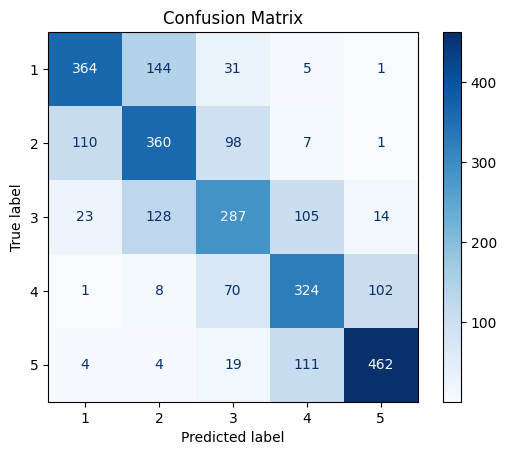

In [11]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

predictions = trainer.predict(sampled_dataset['validation'])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       545
           1       0.56      0.62      0.59       576
           2       0.57      0.52      0.54       557
           3       0.59      0.64      0.61       505
           4       0.80      0.77      0.78       600

    accuracy                           0.65      2783
   macro avg       0.65      0.64      0.64      2783
weighted avg       0.65      0.65      0.65      2783



In [16]:
from transformers import pipeline

sentiment_analysis = pipeline("text-classification", model="./fine_tuned_model", tokenizer="distilbert-base-uncased")

reviews = [
    "This product is amazing! I love it!",
    "The quality is terrible, and it broke after one use.",
    "It's okay, not the best but not the worst either.",
    "Absolutely fantastic! Exceeded my expectations!",
    "Not what I expected. Very disappointing."
]


for i, review in enumerate(reviews, 1):
    prediction = sentiment_analysis(review)
    predicted_label = prediction[0]['label']
    predicted_rating = int(predicted_label.split('_')[-1]) + 1
    print(f"Review {i}: {review}")
    print(f"Predicted Rating: {predicted_rating}\n")

Device set to use cuda:0


Review 1: This product is amazing! I love it!
Predicted Rating: 5

Review 2: The quality is terrible, and it broke after one use.
Predicted Rating: 1

Review 3: It's okay, not the best but not the worst either.
Predicted Rating: 3

Review 4: Absolutely fantastic! Exceeded my expectations!
Predicted Rating: 5

Review 5: Not what I expected. Very disappointing.
Predicted Rating: 2

